<a href="https://colab.research.google.com/github/Saurav2910/Cat-Dog-Classification/blob/master/MobileNet_Cats_vs_Dogs_Classification_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation and Transfer Learning

# Apply Transfer Learning

Load MobileNet and use it as feature extractor with pre-trained CNN weights.

Load Cats and dogs images and use it for Transfer Learning.

Make sure you have the following data file in the current folder: **cat_dog_sub.zip**

We also use Keras ImageDataGenerator for data augmentation.




In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D,Dropout
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

## Load the Pre-trained MobileNet Model

### Let's check the Original MobileNet Model

In [2]:
original_model = MobileNet(weights='imagenet')
original_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

In [3]:
# Take the pre-trained model
# We don't need the last layer of the model - the softmax layer with 1000 outputs
base_model = MobileNet(weights='imagenet', include_top=False)

17227776/17225924 [==============================] - 0s 0us/step


In [4]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

## Tune the Model as per Our Requirements

In [5]:
# 2-class classification - cat vs. dog
CLASSES = 2

# Take the output from the model
# Note that the base model has a Convolutional Layer as the Last Layer
x = base_model.output

# Apply pooling
x = GlobalAveragePooling2D(name='avg_pool')(x)

# Apply regularization
x = Dropout(0.4)(x)

# Add the output layer with Softmax activation for 2-class classification
predictions = Dense(CLASSES, activation='softmax')(x)

# Set the final input and output of the model
model = Model(inputs=base_model.input, outputs=predictions)

### Freeze all the previous layers of the loaded Model

In [6]:
for layer in base_model.layers:
    layer.trainable = False

### Compile the Model with Suitable Parameters

In [7]:
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)   

In [9]:
!unzip cat_dog_sub.zip

Archive:  cat_dog_sub.zip
  inflating: cat_dog_sub/.DS_Store   
   creating: cat_dog_sub/test/
  inflating: cat_dog_sub/test/.DS_Store  
   creating: cat_dog_sub/test/cat/
  inflating: cat_dog_sub/test/cat/10011.jpg  
  inflating: cat_dog_sub/test/cat/10017.jpg  
  inflating: cat_dog_sub/test/cat/10023.jpg  
  inflating: cat_dog_sub/test/cat/10026.jpg  
  inflating: cat_dog_sub/test/cat/10027.jpg  
  inflating: cat_dog_sub/test/cat/10029.jpg  
  inflating: cat_dog_sub/test/cat/1006.jpg  
  inflating: cat_dog_sub/test/cat/10063.jpg  
  inflating: cat_dog_sub/test/cat/10066.jpg  
  inflating: cat_dog_sub/test/cat/10068.jpg  
  inflating: cat_dog_sub/test/cat/10073.jpg  
  inflating: cat_dog_sub/test/cat/10075.jpg  
  inflating: cat_dog_sub/test/cat/10085.jpg  
  inflating: cat_dog_sub/test/cat/10088.jpg  
  inflating: cat_dog_sub/test/cat/10089.jpg  
  inflating: cat_dog_sub/test/cat/10128.jpg  
  inflating: cat_dog_sub/test/cat/10136.jpg  
  inflating: cat_dog_sub/test/cat/10142.jpg  
 

In [10]:
!pwd


/content


In [11]:
os.listdir('cat_dog_sub')

['test', '.DS_Store', 'train']

In [ ]:
# !rm -rf /content/cat_dog_sub/.DS_Store

In [ ]:
# !rm -rf /content/__MACOSX

### Read Data from the Designated Folder and Create Synthetic Images from the Original with Data Augmentation

In [12]:
WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32
TRAIN_DIR=r'/content/cat_dog_sub/train'
TEST_DIR=r'/content/cat_dog_sub/test'
# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 1999 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [13]:
!pwd

/content


In [14]:
data = next(train_generator)

In [15]:
data[1].shape

(32, 2)

In [16]:
import tensorflow as tf

In [17]:
train_generator.n

1999

In [18]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = train_generator.n//train_generator.batch_size
VALIDATION_STEPS=validation_generator.n//train_generator.batch_size

In [19]:
STEPS_PER_EPOCH,VALIDATION_STEPS

(62, 62)

## Train the Model

In [20]:
model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,verbose=1)

Epoch 1/5
62/62 [==============================] - 82s 1s/step - loss: 0.4093 - accuracy: 0.8144 - val_loss: 0.1429 - val_accuracy: 0.9496
Epoch 2/5
62/62 [==============================] - 84s 1s/step - loss: 0.1792 - accuracy: 0.9314 - val_loss: 0.0916 - val_accuracy: 0.9718
Epoch 3/5
62/62 [==============================] - 83s 1s/step - loss: 0.1285 - accuracy: 0.9517 - val_loss: 0.0835 - val_accuracy: 0.9698
Epoch 4/5
62/62 [==============================] - 83s 1s/step - loss: 0.1060 - accuracy: 0.9563 - val_loss: 0.0749 - val_accuracy: 0.9733
Epoch 5/5
62/62 [==============================] - 82s 1s/step - loss: 0.1002 - accuracy: 0.9593 - val_loss: 0.0632 - val_accuracy: 0.9768


## Prediction of the Model

In [21]:
from tensorflow.keras.preprocessing import image

In [36]:
img = image.load_img(r'cat_dog_sub/test/dog/182.jpg', target_size=(299,299))
#img = image.load_img(r'cat_dog_sub/test/dog/105.jpg', target_size=(299,299))

#img = image.load_img(r'cat_dog_sub/test/cat/1006.jpg', target_size=(299,299))
#img = image.load_img(r'cat_dog_sub/test/cat/4158.jpg', target_size=(299,299))


In [37]:
x = image.img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)


In [38]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

In [39]:
train_generator.image_shape

(299, 299, 3)

In [41]:
pred = model.predict(x)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


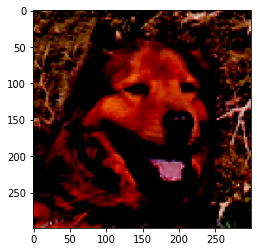

In [42]:
import matplotlib.pyplot as plt
plt.imshow(x[0,:,:,:])

In [43]:
pred

array([4.944330e-06, 9.999951e-01], dtype=float32)